# AI Assignement



Install libraries that are not present in Google Colab.

In [ ]:
pip install pydicom

Libraries

In [ ]:
import torch
import pydicom
import matplotlib.pyplot as plt
import matplotlib.patches as patch
import numpy as np
from google.colab import drive
import cv2
import os
import pandas as pd
from pydicom.pixel_data_handlers.util import apply_voi_lut
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch import nn
import torchvision.models as models
import torch.nn.functional as F

Connect Google Colab to my Google Drive

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Important path

In [ ]:
PATH = "/content/drive/MyDrive/Colab_Notebooks/Data"
csv_file = "/content/drive/MyDrive/Colab_Notebooks/train.csv"

## Process the data

Function to find the maximum dimension for columns and rows (width and height)

In [ ]:
# Defining the function to find the maximum dimensions in a DICOM file
def max_dimension(dicom_path, max_columns, max_rows):
    # Reading the DICOM file located at the specified path
    dicom = pydicom.dcmread(dicom_path)

    # Checking if the number of columns in the DICOM file exceeds the provided maximum columns
    if dicom.Columns > max_columns:
        # If yes, updating the maximum columns to the value in the DICOM file
        max_columns = dicom.Columns

    # Checking if the number of rows in the DICOM file exceeds the provided maximum rows
    if dicom.Rows > max_rows:
        # If yes, updating the maximum rows to the value in the DICOM file
        max_rows = dicom.Rows

    # Returning the updated maximum columns and rows
    return max_columns, max_rows

Function to process the data

In [ ]:
# Define the function to process DICOM data
def process_data(dicom_path, max_columns, max_rows, voi_lut):

    # Initialize a list to store image padding
    image_padding = []

    # Read the DICOM file located at the specified path
    dicom = pydicom.dcmread(dicom_path)
    # Extract pixel data from DICOM
    data_image = dicom.pixel_array

    # Apply VOI LUT if available
    if voi_lut:
        data_image = apply_voi_lut(dicom.pixel_array, dicom)

    # Adjust pixel data based on Photometric Interpretation
    if dicom.PhotometricInterpretation == "MONOCHROME1":
        data_image = np.amax(data_image) - data_image

    # Normalize pixel data if the number of bits stored is not 16
    if dicom.BitsStored != 16:
        pixel_min = np.min(data_image)
        pixel_max = np.max(data_image)
        pixel_array_normalized = (data_image - pixel_min) / (pixel_max - pixel_min)
        new_bits_stored = 16
        new_pixel_max = (2 ** new_bits_stored) - 1
        data_image = (pixel_array_normalized * new_pixel_max).astype(np.uint16)

    # Resize the image to match the maximum columns and rows
    data_image_resize = data_image

    # Calculate padding dimensions
    padding_height = (max_rows - dicom.Rows) / 2
    padding_width = (max_columns - dicom.Columns) / 2

    # Handle odd padding dimensions
    if padding_height % 2 != 0:
        padding_height_1 = padding_height + 0.5
        padding_height_2 = padding_height_1 - 0.5

    if padding_height % 2 == 0:
        padding_height_1 = padding_height_2 = padding_height

    if padding_width % 2 != 0:
        padding_width_1 = padding_width + 0.5
        padding_width_2 = padding_width_1 - 0.5

    if padding_width % 2 == 0:
        padding_width_1 = padding_width_2 = padding_width

    # Convert padding dimensions to integers
    padding_width_1 = int(padding_width_1)
    padding_width_2 = int(padding_width_2)
    padding_height_1 = int(padding_height_1)
    padding_height_2 = int(padding_height_2)

    # Store padding dimensions in a list
    image_padding = [padding_height_1, padding_height_2, padding_width_1, padding_width_2]

    # Pad the image based on calculated padding dimensions
    data_image_resize = np.pad(data_image_resize, ((padding_height_1, padding_height_2), (padding_width_1, padding_width_2)), mode='constant', constant_values=255)

    # Normalize pixel values between 0 and 255
    data_image = data_image - np.min(data_image)
    data_image = data_image / np.max(data_image)
    data_image = (data_image * 255).astype(np.uint8)

    # Downsample the image to one-fourth of its size
    new_height = data_image_resize.shape[0] // 4
    new_width = data_image_resize.shape[1] // 4
    new_image_array = np.zeros((new_height, new_width), dtype=np.uint8)

    for i in range(new_height):
        for j in range(new_width):
            block = data_image_resize[i*4:(i+1)*4, j*4:(j+1)*4]
            new_pixel_value = np.mean(block)
            new_image_array[i, j] = new_pixel_value

    # Normalize pixel values of the resized image
    data_image_resize = new_image_array - np.min(new_image_array)
    data_image_resize = data_image_resize / np.max(data_image_resize)
    data_image_resize = (data_image_resize * 255).astype(np.uint8)

    # Convert grayscale image to RGB
    data_image_resize = np.repeat(data_image_resize[:, :, np.newaxis], 3, axis=2)

    # Return processed image data, resized image data, and image padding
    return data_image, data_image_resize, image_padding

Main of process data

In [ ]:
# Initialize dictionaries to store processed data and padding information
dict_data = {}
dict_data_resize = {}
dict_padding = {}

# Define column titles for the DataFrame
title = ["name", "image", "label", "boxe"]

# Create an empty DataFrame with the defined titles
df = pd.DataFrame(columns=title)

# Get a list of DICOM files in the specified directory
dicom_list = os.listdir(PATH)

# Initialize variables to store maximum rows and columns
max_rows = 0
max_columns = 0

# Iterate through the first 20 DICOM files to find the maximum dimensions
for dicom in dicom_list[:10]:
    max_columns, max_rows = max_dimension(PATH + "/" + dicom, max_columns, max_rows)

# Calculate the maximum dimension (maximum of max_rows and max_columns)
max_dim = max(max_columns, max_rows)

# Set max_columns and max_rows to the calculated maximum dimension
max_columns, max_rows = max_dim, max_dim

# Iterate through the first 20 DICOM files to process data
for dicom in dicom_list[:10]:

    # Process DICOM data and resize images
    dict_data[dicom[:-6]], dict_data_resize[dicom[:-6]], dict_padding[dicom[:-6]] = process_data(PATH + "/" + dicom, max_columns, max_rows, voi_lut=True)

    # Read data from CSV file
    d_images = pd.read_csv(csv_file)

    # Extract DICOM name
    name_dicom = os.path.basename(PATH + "/" + dicom)
    name = name_dicom[:-6]

    # Filter data from CSV corresponding to the DICOM file
    d_image = d_images.loc[d_images.iloc[:, 0] == name]

    # Iterate through rows in the filtered CSV data
    for _, row in d_image.iterrows():

        # Check if label is not "No finding"
        if row[1] != "No finding":
            # Extract padding information
            padding_width_1 = dict_padding[name][2]
            padding_width_2 = dict_padding[name][3]
            padding_height_1 = dict_padding[name][0]
            padding_height_2 = dict_padding[name][1]

            # Calculate coordinates of bounding box
            x_min = row[4] + padding_width_1
            x_max = row[6] + padding_width_1
            y_min = row[5] + padding_height_1
            y_max = row[6] + padding_height_1

            # Create a dictionary row for DataFrame
            row = {"name": dicom[:-6], "image": dict_data_resize[dicom[:-6]], "label": row[2], "boxe": [x_min, x_max, y_min, y_max]}

            # Append the row to the DataFrame
            df = pd.concat([df, pd.DataFrame([row])], ignore_index=True)
        else:
            # Create a dictionary row for DataFrame when label is "No finding"
            row = {"name": dicom[:-6], "image": dict_data_resize[dicom[:-6]], "label": 14, "boxe": [0, 0, 0, 0]}

            # Append the row to the DataFrame
            df = pd.concat([df, pd.DataFrame([row])], ignore_index=True)


/usr/local/lib/python3.10/dist-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (14-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Plot X-ray without anomalies

In [ ]:
def Xray_Plot(pixel,image_name) :

  print(image_name)  # Print the image name or identifier
  # Plot the X-ray image using imshow() function from matplotlib
  # cmap=plt.cm.bone sets the colormap to 'bone' for better visualization
  plt.imshow(pixel, cmap=plt.cm.bone)
  plt.show()  # Display the plot

Plot X-ray with anomalies

In [ ]:
def Xray_Plot_with_anomalies(pixel, image_name, csv_file, dict_color, dict_name) :

    print(image_name)  # Print the image name or identifier

    # Initialize lists to store coordinates and IDs of anomalies
    x_min, x_max, y_min, y_max, id = [], [], [], [], []

    # Read annotations from the CSV file into a pandas DataFrame
    data = pd.read_csv(csv_file)

    id_file = image_name

    # Filter annotations for the current image
    data_image = data.loc[data.iloc[:, 0] == id_file]

    # Create figure and axes
    fig, ax = plt.subplots(1)

    # Display the image
    ax.imshow(pixel, cmap=plt.cm.bone)

    # Iterate over the annotations for the current image
    for _, row in data_image.iterrows():

        if row[1] != "No finding":  # Check if anomaly is present in the current row

            # Append anomaly ID and coordinates to respective lists
            id.append(row[2])
            x_min.append(row[4])
            x_max.append(row[6])
            y_min.append(row[5])
            y_max.append(row[7])

    # Iterate over the annotations to draw bounding boxes and label text
    for el in range(len(x_min)):
        # Create Rectangle patch for the bounding box
        rect = patch.Rectangle((x_min[el], y_min[el]), x_max[el] - x_min[el], y_max[el] - y_min[el],
                         linewidth=1, edgecolor=dict_color[str(id[el])], facecolor="none")

        # Add the rectangle patch to the plot
        ax.add_patch(rect)

        # Add text label for the anomaly
        ax.text(x_min[el], y_min[el] - 20, dict_name[str(id[el])], style='italic', color=dict_color[str(id[el])], size="8")

    plt.show()  # Show the plot

X-ray with a different monochrome

/usr/local/lib/python3.10/dist-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


adaf0261d0c111e5928ba94ab6b36e2d


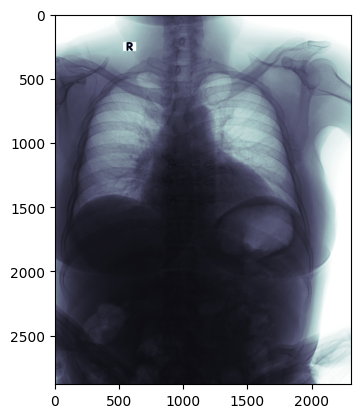

In [ ]:
name = "adaf0261d0c111e5928ba94ab6b36e2d"

# Read the DICOM file located at the specified path
dicom = pydicom.dcmread(PATH + "/" + name + ".dicom")
# Extract pixel data from DICOM
data_image = dicom.pixel_array

Xray_Plot(data_image, name)

X-ray without anomalies


b8202fc93f201492ab7880cb6b4c9165


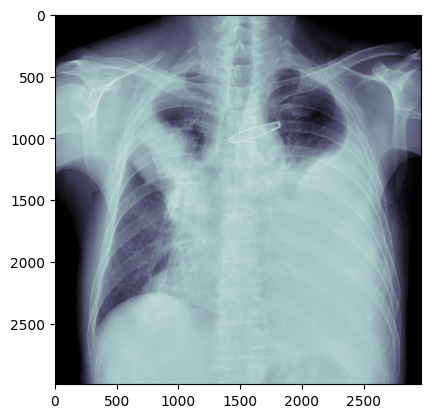

In [ ]:
name = "b8202fc93f201492ab7880cb6b4c9165"

Xray_Plot(dict_data[name], name)

X-ray with anomalies

b8202fc93f201492ab7880cb6b4c9165


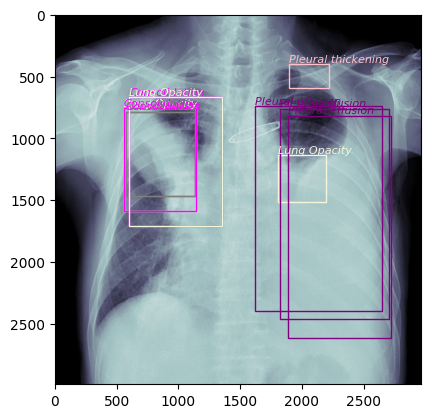

In [ ]:
name = "b8202fc93f201492ab7880cb6b4c9165"

dict_name = {
    "0" : "Aortic enlargement",
    "1" : "Atelectasis",
    "2" : "Calcification",
    "3" : "Cardiomegaly",
    "4" : "Consolidation",
    "5" : "ILD",
    "6" : "Infiltration",
    "7" : "Lung Opacity",
    "8" : "Nodule/Mass",
    "9" : "Other lesion",
    "10" : "Pleural effusion",
    "11" : "Pleural thickening",
    "12" : "Pneumothorax",
    "13" : "Pulmonary fibrosis",
}

dict_color = {
    "0" : "red",
    "1" : "green",
    "2" : "blue",
    "3" : "cyan",
    "4" : "magenta",
    "5" : "yellow",
    "6" : "turquoise",
    "7" : "beige",
    "8" : "gray",
    "9" : "orange",
    "10" : "purple",
    "11" : "pink",
    "12" : "brown",
    "13" : "lavender",
}

Xray_Plot_with_anomalies(dict_data[name], name,csv_file, dict_color, dict_name)

X-ray with padding

b8202fc93f201492ab7880cb6b4c9165


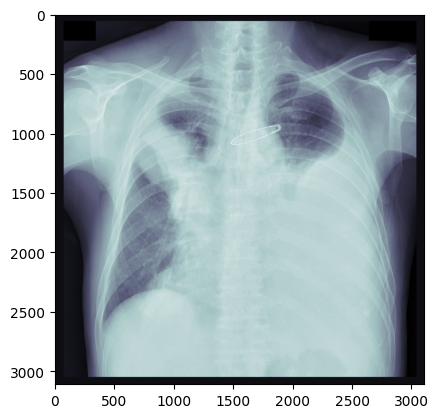

In [ ]:
name = "b8202fc93f201492ab7880cb6b4c9165"

# Read the DICOM file located at the specified path
dicom = pydicom.dcmread(PATH + "/" + name + ".dicom")
# Extract pixel data from DICOM
data_image = dicom.pixel_array

data_image_resize = np.pad(data_image, ((dict_padding[name][0], dict_padding[name][1]), (dict_padding[name][2], dict_padding[name][3])), mode='constant', constant_values=255)

Xray_Plot(data_image_resize, name)

## Dataset

Create a mask to show anomalies

In [ ]:
def create_mask(bb, x):
    # Extract the dimensions of the image
    rows, cols, *_ = x.shape

    # Initialize a zero matrix for the mask
    Y = np.zeros((rows, cols))

    # Convert bounding box coordinates to integers
    for i in range(len(bb)):
        bb[i] = int(bb[i])

    # Set the region defined by the bounding box to 1
    Y[bb[0]:bb[2], bb[1]:bb[3]] = 1.

    return Y

def mask_to_bb(Y):
    # Find the row and column indices of non-zero elements in the mask
    cols, rows = np.nonzero(Y)

    # If there are no non-zero elements (no mask), return a zero bounding box
    if len(cols) == 0:
        return np.zeros(4, dtype=np.float32)

    # Calculate the coordinates of the bounding box
    top_row = np.min(rows)
    left_col = np.min(cols)
    bottom_row = np.max(rows)
    right_col = np.max(cols)

    # Return the bounding box coordinates as a numpy array
    return np.array([left_col, top_row, right_col, bottom_row], dtype=np.float32)

Apply the mask

In [ ]:
def transformboxe(image, boxe):
    # Assign the input image to a variable
    x = image

    # Create a binary mask based on the bounding box and the image
    Y = create_mask(boxe, x)

    # Convert the mask to bounding box coordinates
    bounding_box = mask_to_bb(Y)

    # Return the original image and the bounding box coordinates
    return x, bounding_box

Dataset class to create Dataset

In [ ]:
class CreateDataset(Dataset):
    def __init__(self, image, boxe, label):
        # Extract and store image, bounding box, and label data as numpy arrays
        self.image = image.values
        self.boxe = boxe.values
        self.label = label.values

    def __len__(self):
        # Return the length of the dataset
        return len(self.image)

    def __getitem__(self, idx):
        # Retrieve image, label, and bounding box for the given index
        image = self.image[idx]
        y_label = self.label[idx]

        # Transform the bounding box for the image
        x, y_boxe = transformboxe(image, self.boxe[idx])

        # Return the transformed image, label, and bounding box
        return x, y_label, y_boxe

Main of create Dataset

In [ ]:
# Splitting the DataFrame into Train and Validation Sets:
# Randomly sample 80% of the rows from the DataFrame to create the training dataset
train_df = df.sample(frac=0.8, random_state=42)
# Create the validation dataset by dropping the rows used for training from the original DataFrame
val_df = df.drop(train_df.index)
# Reset the index of the training DataFrame after the split
train_df.reset_index(drop=True, inplace=True)
# Reset the index of the validation DataFrame after the split
val_df.reset_index(drop=True, inplace=True)

# Creating Dataset Instances:
# Create an instance of the CreateDataset class for the training dataset
dataset_train = CreateDataset(train_df["image"], train_df["boxe"], train_df["label"])
# Create an instance of the CreateDataset class for the validation dataset
dataset_val = CreateDataset(val_df["image"], val_df["boxe"], val_df["label"])

# Defining DataLoader Parameters:
# Set the batch size for both training and validation DataLoaders
batch_size = 10
# Specify whether to shuffle the data at the beginning of each epoch during training for better generalization
shuffle = True

# Creating DataLoader Objects:
# Create a DataLoader object for the training dataset with the specified batch size and shuffle settings
train_dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=shuffle)
# Create a DataLoader object for the validation dataset with the specified batch size
val_dataloader = DataLoader(dataset_val, batch_size=batch_size)


## Model

My try at implemanting ResNet-34.

In [ ]:
# class ResidualBlock(nn.Module):
#     def __init__(self, in_channels, out_channels, stride=2, kernel_size=7, padding=3, bias=False):
#         super(ResidualBlock, self).__init__()

#         # CNN layers for the first convolutional block
#         self.cnn1 = nn.Sequential(
#             nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
#             nn.BatchNorm2d(out_channels),
#             nn.ReLU(True)
#         )

#         # CNN layers for the second convolutional block
#         self.cnn2 = nn.Sequential(
#             nn.Conv2d(out_channels, out_channels, kernel_size, 1, padding, bias=False),
#             nn.BatchNorm2d(out_channels)
#         )

#         # Shortcut connection to adjust dimensions if needed
#         if stride != 1 or in_channels != out_channels:
#             self.shortcut = nn.Sequential(
#                 nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
#                 nn.BatchNorm2d(out_channels)
#             )
#         else:
#             self.shortcut = nn.Sequential()

#     def forward(self, x):
#         # Save the residual for later use
#         residual = x

#         # Forward pass through the first convolutional block
#         x = self.cnn1(x)

#         # Forward pass through the second convolutional block
#         x = self.cnn2(x)

#         # Add the shortcut connection
#         x += self.shortcut(residual)

#         # Apply ReLU activation
#         x = nn.ReLU(True)(x)
#         print("R :", x.shape)
#         return x


# class ResNet34(nn.Module):
#     def __init__(self, in_channels, out_channels):
#         super(ResNet34, self).__init__()

#         # Initial convolutional block
#         self.block1 = nn.Sequential(
#             nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False),
#             nn.BatchNorm2d(64),
#             nn.ReLU(True)
#         )

#         # Residual blocks
#         self.block2 = nn.Sequential(
#             nn.MaxPool2d(1, 1),
#             ResidualBlock(64, 64),
#             ResidualBlock(64, 64, 2)
#         )

#         self.block3 = nn.Sequential(
#             ResidualBlock(64, 128),
#             ResidualBlock(128, 128, 2)
#         )

#         self.block4 = nn.Sequential(
#             ResidualBlock(128, 256),
#             ResidualBlock(256, 256, 2)
#         )

#         self.block5 = nn.Sequential(
#             ResidualBlock(256, 512),
#             ResidualBlock(512, 512, 2)
#         )

#         # Average pooling layer
#         self.avgpool = nn.AvgPool2d(2)

#         # Fully connected layer for classification
#         self.fc1 = nn.Linear(512, 15)

#     def forward(self, x):
#         # Forward pass through the network
#         x = self.block1(x)
#         x = self.block2(x)
#         x = self.block3(x)
#         x = self.block4(x)
#         x = self.block5(x)
#         x = self.avgpool(x)
#         x = x.view(x.size(0), -1)
#         x1 = self.fc1(x)
#         print("Res :", x1.shape)
#         return x1


# class NeuralNetwork(nn.Module):
#     def __init__(self):
#         super(NeuralNetwork, self).__init__()

#         # Define the ResNet34 model instance
#         r1 = ResNet34(1, 1)

#         # Feature extraction layers
#         self.features1 = nn.Sequential(r1)

#         # Classifier for classification task
#         self.classifier = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 15))

#         # Bounding box regression layer
#         self.bb = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 15))

#     def forward(self, x):
#         # Add a channel dimension to the input tensor
#         x = x.unsqueeze(1)

#         # Forward pass through the feature extraction layers
#         x = self.features1(x)

#         # Apply ReLU activation
#         x = F.relu(x)

#         # Apply adaptive average pooling
#         x = nn.AdaptiveAvgPool2d((1, 1))(x)

#         # Flatten the feature maps
#         x = x.view(x.shape[0], -1)
#         print("NN :", x.shape)

#         # Forward pass through the classifier and bounding box regression layers
#         return self.classifier(x), self.bb(x)



Functionnal model

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()

        # Load a pre-trained ResNet34 model
        resnet = models.resnet34(pretrained=True)

        # Extract the first 8 layers of the ResNet34 model
        layers = list(resnet.children())[:8]

        # Define feature extraction layers for the first part of the network
        self.features1 = nn.Sequential(*layers[:6])

        # Define feature extraction layers for the second part of the network
        self.features2 = nn.Sequential(*layers[6:])

        # Define the classifier layer for classification task
        self.classifier = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 15))

        # Define the bounding box regression layer
        self.bb = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 4))

    def forward(self, x):
        # Permute input tensor to match expected format (batch_size, channels, height, width)
        x = x.permute(0, 3, 1, 2)

        # Extract features using the first set of layers
        x = self.features1(x)

        # Extract features using the second set of layers
        x = self.features2(x)

        # Apply ReLU activation function
        x = F.relu(x)

        # Apply adaptive average pooling to convert spatial dimensions to (1, 1)
        x = nn.AdaptiveAvgPool2d((1,1))(x)

        # Flatten the feature maps
        x = x.view(x.shape[0], -1)

        # Forward pass through the classifier layer to get classification output
        classification_output = self.classifier(x)

        # Forward pass through the bounding box regression layer to get bounding box predictions
        bounding_box_output = self.bb(x)

        # Return both classification output and bounding box predictions
        return classification_output, bounding_box_output


Validation (GPU/CPU)




In [ ]:
# def val_metrics(model, valid_dl, C=1000):
#     # Set the model to evaluation mode
#     model.eval()

#     # Initialize variables for calculating metrics
#     total = 0
#     sum_loss = 0
#     correct = 0

#     # Loop through the validation data loader
#     for x, y_class, y_bb in valid_dl:
#         batch = y_class.shape[0]  # Get the batch size
#         x = x.cuda().float()  # Move input data to GPU and convert to float
#         y_class = y_class.cuda()  # Move class labels to GPU
#         y_bb = y_bb.cuda().float()  # Move bounding box labels to GPU and convert to float

#         # Perform forward pass through the model
#         out_class, out_bb = model(x)

#         # Calculate classification loss using cross-entropy loss
#         loss_class = F.cross_entropy(out_class, y_class, reduction="sum")

#         # Calculate bounding box loss using L1 loss
#         loss_bb = F.l1_loss(out_bb, y_bb, reduction="none").sum(1)
#         loss_bb = loss_bb.sum()

#         # Calculate total loss as a combination of classification and bounding box losses
#         loss = loss_class + loss_bb/C

#         # Compute accuracy by comparing predicted class labels with ground truth labels
#         _, pred = torch.max(out_class, 1)
#         correct += pred.eq(y_class).sum().item()

#         # Accumulate total loss
#         sum_loss += loss.item()

#         # Accumulate total number of samples
#         total += batch

#     # Calculate average loss and accuracy
#     return sum_loss/total, correct/total

def val_metrics(model, valid_dl, C=1000):
    # Set the model to evaluation mode
    model.eval()

    # Initialize variables for calculating metrics
    total = 0
    sum_loss = 0
    correct = 0

    # Use CPU for validation
    device = torch.device("cpu")

    # Loop through the validation data loader
    for x, y_class, y_bb in valid_dl:
        batch = y_class.shape[0]  # Get the batch size
        x = x.to(device).float()  # Move input data to CPU and convert to float
        y_class = y_class.to(device)  # Move class labels to CPU
        y_bb = y_bb.to(device).float()  # Move bounding box labels to CPU and convert to float

        # Perform forward pass through the model
        out_class, out_bb = model(x)

        # Calculate classification loss using cross-entropy loss
        loss_class = F.cross_entropy(out_class, y_class, reduction="sum")

        # Calculate bounding box loss using L1 loss
        loss_bb = F.l1_loss(out_bb, y_bb, reduction="none").sum(1)
        loss_bb = loss_bb.sum()

        # Calculate total loss as a combination of classification and bounding box losses
        loss = loss_class + loss_bb/C

        # Compute accuracy by comparing predicted class labels with ground truth labels
        _, pred = torch.max(out_class, 1)
        correct += pred.eq(y_class).sum().item()

        # Accumulate total loss
        sum_loss += loss.item()

        # Accumulate total number of samples
        total += batch

    # Calculate average loss and accuracy
    return sum_loss/total, correct/total


Train (GPU/CPU)

In [ ]:
# def train(model, optimizer, train_dl, val_dl, epochs=10, C=1000):
#     idx = 0  # Initialize the index for tracking iterations
#     for i in range(epochs):  # Iterate over the specified number of epochs
#         model.train()  # Set the model to training mode
#         total = 0  # Initialize variable to store total number of samples
#         sum_loss = 0  # Initialize variable to store total loss

#         # Iterate over the training data loader
#         for x, y_class, y_bb in train_dl:
#             batch = y_class.shape[0]  # Get the batch size
#             x = x.cuda().float()  # Move input data to GPU and convert to float
#             y_class = y_class.cuda()  # Move class labels to GPU
#             y_bb = y_bb.cuda().float()  # Move bounding box labels to GPU and convert to float

#             # Perform forward pass through the model
#             out_class, out_bb = model(x)

#             # Calculate classification loss using cross-entropy loss
#             loss_class = F.cross_entropy(out_class, y_class, reduction="sum")

#             # Calculate bounding box loss using L1 loss
#             loss_bb = F.l1_loss(out_bb, y_bb, reduction="none").sum(1)
#             loss_bb = loss_bb.sum()

#             # Calculate total loss as a combination of classification and bounding box losses
#             loss = loss_class + loss_bb/C

#             # Zero the gradients
#             optimizer.zero_grad()

#             # Perform backward pass to calculate gradients
#             loss.backward()

#             # Update the parameters
#             optimizer.step()

#             idx += 1  # Increment the iteration index
#             total += batch  # Accumulate total number of samples
#             sum_loss += loss.item()  # Accumulate total loss

#         train_loss = sum_loss/total  # Calculate average training loss

#         # Calculate validation loss and accuracy
#         val_loss, val_acc = val_metrics(model, val_dl, C)

#         # Print training and validation metrics
#         print("train_loss %.3f val_loss %.3f val_acc %.3f" % (train_loss, val_loss, val_acc))

#     # Return the final training loss
#     return sum_loss/total


def train(model, optimizer, train_dl, val_dl, epochs=10, C=1000):
    idx = 0  # Initialize the index for tracking iterations
    device = torch.device("cpu")  # Set the device to CPU
    for i in range(epochs):  # Iterate over the specified number of epochs
        print(f"\n\nEpoch {i+1}\n-------------------------------")
        model.train()  # Set the model to training mode
        total = 0  # Initialize variable to store total number of samples
        sum_loss = 0  # Initialize variable to store total loss

        # Iterate over the training data loader
        for x, y_class, y_bb in train_dl:
            batch = y_class.shape[0]  # Get the batch size
            x = x.to(device).float()  # Move input data to CPU and convert to float
            y_class = y_class.to(device)  # Move class labels to CPU
            y_bb = y_bb.to(device).float()  # Move bounding box labels to CPU and convert to float

            # Perform forward pass through the model
            out_class, out_bb = model(x)

            # Calculate classification loss using cross-entropy loss
            loss_class = F.cross_entropy(out_class, y_class, reduction="sum")

            # Calculate bounding box loss using L1 loss
            loss_bb = F.l1_loss(out_bb, y_bb, reduction="none").sum(1)
            loss_bb = loss_bb.sum()

            # Calculate total loss as a combination of classification and bounding box losses
            loss = loss_class + loss_bb/C

            # Zero the gradients
            optimizer.zero_grad()

            # Perform backward pass to calculate gradients
            loss.backward()

            # Update the parameters
            optimizer.step()

            idx += 1  # Increment the iteration index
            total += batch  # Accumulate total number of samples
            sum_loss += loss.item()  # Accumulate total loss
            i += 1  # Increment epoch counter

        train_loss = sum_loss/total  # Calculate average training loss

        # Calculate validation loss and accuracy
        val_loss, val_acc = val_metrics(model, val_dl, C)

        # Print training and validation metrics
        print("train_loss %.3f val_loss %.3f val_acc %.3f" % (train_loss, val_loss, val_acc))

    print("Done !")  # Indicate completion of training

    # Return the final training loss
    return sum_loss/total


Define the divice

In [ ]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


Build the model

In [ ]:
model = NeuralNetwork().to(device)
print(model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 101MB/s]


NeuralNetwork(
  (features1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_sta

Define the optimizer

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.006)

Train the model

In [ ]:
# train(model, optimizer, train_dataloader, val_dataloader, epochs=15)